## svmgauss

From A First Course in Machine Learning, Chapter 5.


Simon Rogers, 01/11/21 [simon.d.rogers@gmail.com]

SVM with a non-linear (Gaussian) kernel

*Note*: this code requires the package `quadprog`. Can be installed with

```
pip install quadprog
```

In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

Generate some data

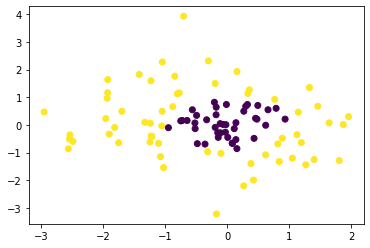

In [6]:
N = 100
X = np.random.multivariate_normal([0, 0], np.eye(2), size=N)
# compute distance of each point from origin - those with distance <= 1 will be in class -1
r = np.sqrt((X**2).sum(axis=1))
t = np.ones((N, 1))
thresh = 1.
pos = np.where(r <= thresh)[0]
t[pos] = -1 * t[pos]
plt.scatter(X[:, 0], X[:, 1], c=t)

Essentially the same SVM class as before, but now with additional kernels implemented

In [29]:
import quadprog

class LinearKernel(object):
    def compute_gram(self, X1, X2=None):
        if X2 is None:
            return self._gram(X1, X1)
        else:
            return self._gram(X1, X2)
        
    def _gram(self, X1, X2):
        return np.dot(X1, X2.T)
    def __str__(self):
        return "Linear kernel"
    
class GaussianKernel(LinearKernel):
    def __init__(self, gamma):
        self.gamma = gamma
    def _gram(self, X1, X2):
        N1, _ = X1.shape
        N2, _ = X2.shape
        K = np.zeros((N1, N2), float)
        for n in range(N1):
            for m in range(N2):
                di_vec = X1[n, :] - X2[m, :]
                K[n, m] = np.exp(-self.gamma * (di_vec**2).sum())
        return K
    def __str__(self):
        return f"Gaussian kernel, gamma = {self.gamma}"


# Not used below, but try swapping it in. Gamma is now the power.
class PolynomialKernel(GaussianKernel):
    def _gram(self, X1, X2):
        temp = np.dot(X1, X2.T)
        return (1 + temp)**self.gamma

class SVM(object):
    def __init__(self, X, t, C=1e6, kernel=LinearKernel()):
        self.X = X
        self.t = t
        self.kernel = kernel
        self.C = C
        self.K = self.kernel.compute_gram(X)
        self.N, _ = self.X.shape
    
    def train(self):
        a = np.ones(self.N) # multiplier for linear term
        tt = np.dot(self.t, self.t.T)
        G = (self.K * tt) + 1e-10*np.eye(self.N) # quadratic term (1e-10 for numerical stability)
        C = np.hstack((self.t, np.eye(self.N), -1*np.eye(self.N))) # constraints (equality and then inequality)
        b = np.hstack((np.zeros(1), np.zeros(self.N), -self.C*np.ones(self.N))) # constraints
        self.alp, _, _, _, _, _ = quadprog.solve_qp(G, a, C, b, meq=1)
        
        # compute b
        self.compute_b()
        return self # allows instantiations and train in one command
    
    def compute_b(self):
        # find the SV with the highest value of sum_m alpha_m t_m K(x_m, x_n)
        temp = (self.alp*self.t.flatten()*self.K).sum(axis=0)
        sv_pos = np.argmax(temp)
        self.b = self.t[sv_pos] - (self.alp*self.t.flatten()*self.K[sv_pos, :]).sum()
        
    def classify(self, testX):
        '''
        Compute raw classification (real) value
        '''
        testK = self.kernel.compute_gram(self.X, testX)
        temp = (self.alp*self.t.flatten())[:, None]*testK
        temp = temp.sum(axis=0) + self.b
        return temp

    def classify_labels(self, testX):
        '''
        Compute predicted label
        '''
        temp = self.classify(testX)
        temp = 1*(temp > 0)
        temp = 2 * temp - 1
        return temp
    
    def get_svs(self, thresh=1e-5):
        '''
        Get the SVs
        '''
        pos = np.where(self.alp >= thresh)[0]
        return self.X[pos,:]
    
    def __str__(self):
        return f'SVM ({self.kernel}), C = {self.C}'

Contour plotting method

In [32]:
def plot_contours(X, t, classifier, MIN_X=-2,
                  MAX_X=6, MIN_Y=-2, MAX_Y=5,
                  n_x=50, n_y=60, levels=[0.5]):
    
    xv = np.linspace(MIN_X, MAX_X, n_x)
    yv = np.linspace(MIN_Y, MAX_Y, n_y)
    
    Xg, Yg = np.meshgrid(xv, yv)
    
    gridX = np.hstack((
        Xg.ravel()[:, None],
        Yg.ravel()[:, None]
    ))
    
    preds = classifier.classify(gridX)

    Z = np.reshape(preds, (n_y, n_x))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], c=t)
    CS = ax.contour(Xg, Yg, Z, levels=levels, colors='k')
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_title(str(classifier))
    return ax

Train the classifier and plot the contours

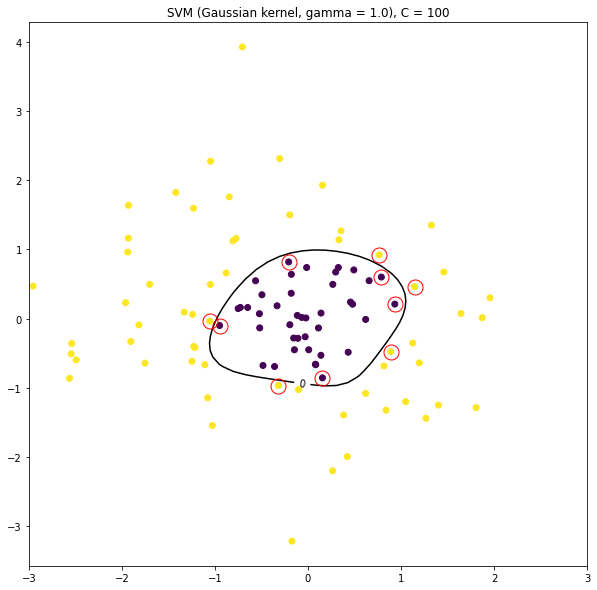

In [33]:
C = 100
svm = SVM(X, t, kernel=GaussianKernel(1.0), C=C).train()
ax = plot_contours(X, t, svm, levels=[0.0], MIN_X=-3, MAX_X=3, MIN_Y=-3, MAX_Y=3)
svs = svm.get_svs(thresh=1e-5)
ax.plot(svs[:,0], svs[:, 1], 'ro', markersize=15, markerfacecolor='none')